# Urban and rural surrounding areas selection

***
> This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0)
>
> ![Creative Commons License >](https://i.creativecommons.org/l/by/4.0/88x31.png)

## Load libraries

Here we load the required libraries to execute the notebook. Note that specific code from dedicated scripts (`utils.py`, `urban_areas.py`, ...) is also loaded here.

In [1]:
import os
import numpy as np
import xarray as xr
import cf_xarray as cfxr
from pathlib import Path
import glob
import re
import geopandas as gpd
import pandas as pd



from urbanmask.urban_areas import (
    Urban_vicinity,
)

from urbanmask.UHI_plot_functions import (
    plot_climatology,
    plot_annual_cicle,
    plot_daily_cicle
)

from urbanmask.utils import (
    kelvin2degC,
    traverseDir,
    fix_360_longitudes,
)

## Input parameters

These parameters define the behaviour of the notebook, by selecting the `city`, `variable`, and some other items which are mostly self-explanatory. _(Explain here those with are not)_

In [2]:
city = 'Cordoba'
lon_city = -64.1888
lat_city = -31.4201

domain = 'CSAM-4i'
model = 'UCAN'
scenario = "evaluation"

urban_th = 60
urban_sur_th = 1
orog_diff = 100
sftlf_th = 70
scale = 2
min_city_size = 3
lon_lim = 1
lat_lim = 1

urban_var = 'sftuf'

variable='tasmin'

Create a directory to save the results for this particular city and model

In [3]:
base_output_dir = 'results'
output_dir = f"{base_output_dir}/{city}-{domain}_{model}-WRF433-v1"
os.makedirs(output_dir, exist_ok = True)

Infer doman resolution in degrees and create filename

In [4]:
domain_resolution = int( re.search(r'(\d+)', domain.split('-')[1]).group(1))
base_filename = f'{city}-{domain}_{model}-WRF433-v1_{scenario}_r1i1p1f1'

## Define urban areas and vicinity

### Load static variables
Load static variables, such as urban fraction (sfturf), terrain elevation (orography) or land-sea fraction (sftlf).

In [5]:
root = f'/lustre/gmeteo/WORK/ASNA/projects/fpssam/03_FPS-SESA-ext-CPM/data/CORDEX-FPS-SESA/output/{domain}/{model}/*/evaluation/*/{model}-*/v1/'
#if model == "USP":
#    root = '/lustre/gmeteo/WORK/ASNA/projects/fpssam/03_FPS-SESA-ext-CPM/data/CORDEX-FPS-SESA/output/CSAM-4i/USP/ECMWF-ERA5/evaluation/r1i1p1f1/USP-RegCM471/v2/'

In [6]:
file_pattern = f'{root}fx/landuse/landuse_{domain}_*.nc'
file_list = glob.glob(file_pattern)
ds_sftuf = xr.open_dataset(file_list[0], engine='netcdf4')


file_pattern = f'{root}fx/orog/orog_{domain}_*.nc'
file_list = glob.glob(file_pattern)
ds_orog = xr.open_dataset(file_list[0], engine='netcdf4')

file_pattern = f'{root}fx/sftlf/sftlf_{domain}_*.nc'
file_list = glob.glob(file_pattern)
ds_sftlf = xr.open_dataset(file_list[0], engine='netcdf4')

ds_sftuf['sftuf'] = (ds_sftuf['landuse'] == 13)*100

Add parameters to the function

In [7]:
URBAN = Urban_vicinity(
    urban_th, 
    urban_sur_th, 
    orog_diff, 
    sftlf_th,
    scale,
    min_city_size,
    lon_city,
    lat_city,
    lon_lim,
    lat_lim,
    model,
    domain,
    urban_var)

Crop area around de city

In [8]:
ds_sftuf = URBAN.crop_area_city(ds_sftuf, domain_resolution)
ds_orog = URBAN.crop_area_city(ds_orog, domain_resolution)
ds_sftlf = URBAN.crop_area_city(ds_sftlf, domain_resolution)

Define masks using the parameters above

In [9]:
sftuf_mask, sftuf_sur_mask, orog_mask, sftlf_mask = URBAN.define_masks(
    ds_sftuf, 
    ds_orog, 
    ds_sftlf
)

### Define rural vicinity areas

We use an iterative algorithm to select the urban vicinity excluding masked areas

In [10]:
urmask = URBAN.select_urban_vicinity(
    sftuf_mask, 
    orog_mask,
    sftlf_mask,
    sftuf_sur_mask
)

We can plot the masks and the urban vs vicinity areas. The latter are are passed via the `urban_areas` parameter. They are hidden if set to `None`.

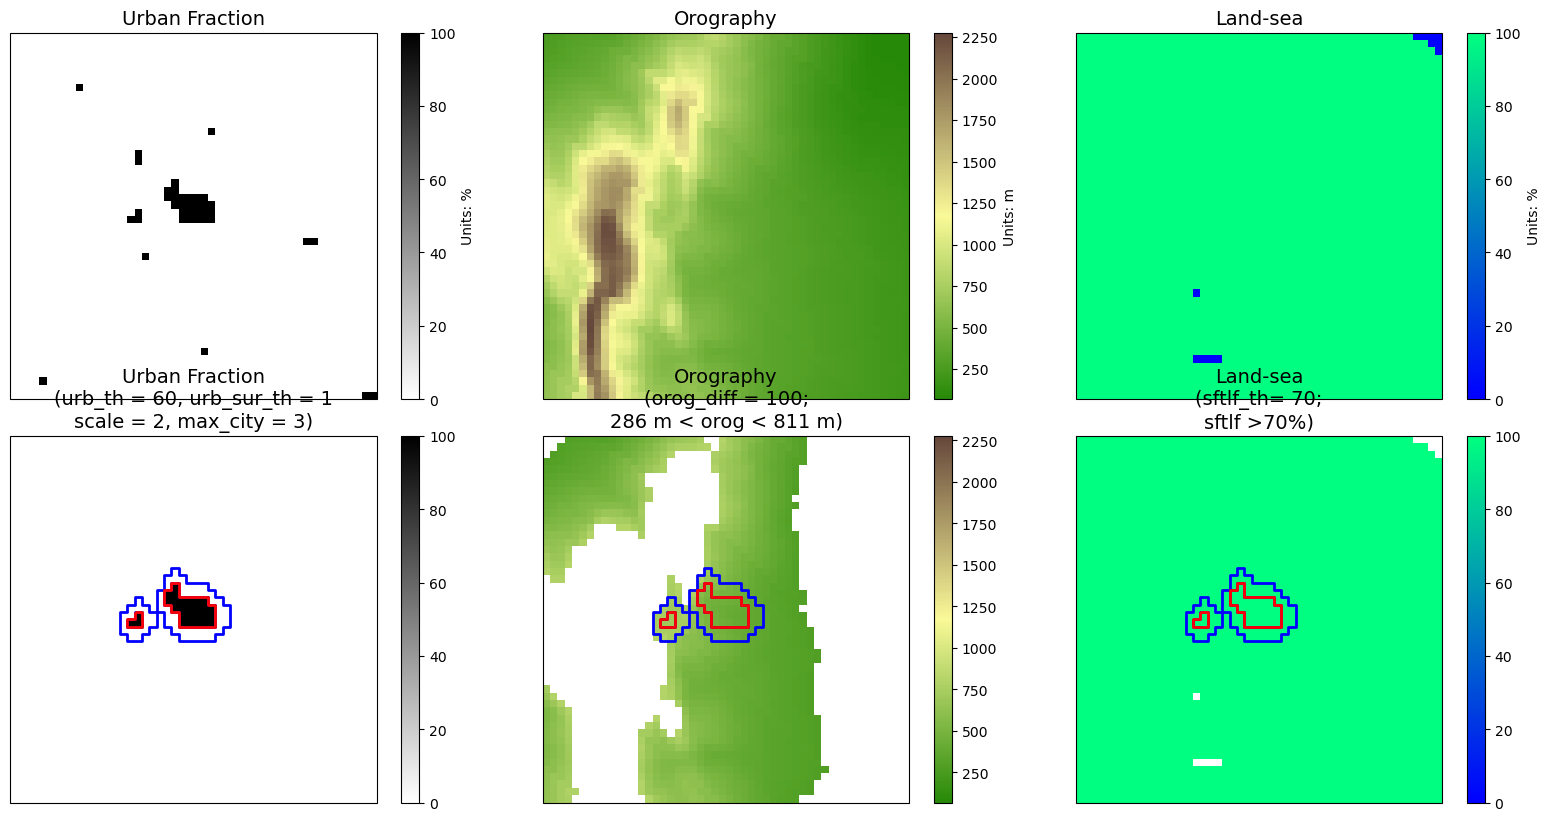

In [11]:
fig = URBAN.plot_static_variables(ds_sftuf, ds_orog, ds_sftlf,
                                 sftuf_mask, orog_mask, sftlf_mask,
                                 urban_areas = urmask)

## Calculate urban heat island effect

### Load climate variable

In [12]:
file_pattern = f'{root}day/{variable}/*'
files = np.sort(glob.glob(file_pattern))
ds_RCM = xr.open_mfdataset(files, concat_dim='time', combine='nested')
ds_RCM = kelvin2degC(ds_RCM, variable)
ds_RCM = fix_360_longitudes(ds_RCM)
ds_RCM = URBAN.crop_area_city(ds_RCM, domain_resolution).compute()

### Load observations

In [13]:
import pandas as pd
loc = {
    'BuenosAires': dict(
        urb=dict(lat=-34.583, lon=-58.500),
        rur=dict(lat=-34.817, lon=-58.533)  # Ezeiza
    ),
    'Cordoba': dict(
        urb=dict(lat=-31.400, lon=-64.167),
        rur=dict(lat=-31.3, lon=-64.127)  # Aero moved to non-urban gridcell
    ),
#    'Porto Alegre': dict(  # made up points
#        urb=dict(lat=-30.032, lon=-51.174),
#        rur=dict(lat=-30.152, lon=-51.061)
#    ),
}

# Crear lista para almacenar las filas
data = []

# Iterar sobre los datos para construir el DataFrame
for place, locations in loc.items():
    for urban_type, coords in locations.items():
        data.append({
            'city': place,
            'urban': 'Urban' if urban_type == 'urb' else 'Rural',
            'lat': coords['lat'],
            'lon': coords['lon']
        })

# Crear el DataFrame
df = pd.DataFrame(data)

In [14]:
import pandas as pd
import os
import glob

def load_city_data(city, base_dir="/lustre/gmeteo/WORK/ASNA/projects/fpssam/03_FPS-SESA-ext-CPM/data/urban_station_data/Datos"):
    """
    Loads and merges data files for a given city, and calculates daily minimum and maximum temperatures.
    Returns two DataFrames: one for urban stations and one for rural stations.
    
    Parameters:
        base_dir (str): The base directory where the files are located.
        city (str): The city name to match the files. The city will be converted to uppercase.
    
    Returns:
        pd.DataFrame, pd.DataFrame: Two DataFrames: one for urban stations and one for rural stations.
    """
    
    # Define the station names for each city
    st_name = {
        'BuenosAires': dict(urb='BSAS-OBS', rur='EZEIZA-AERO'),
        'Cordoba': dict(urb='CORDOBA-OBS', rur='CORDOBA-AERO'),
    }
    # Create search patterns for both urban and rural files
    search_patterns = [
        os.path.join(base_dir, f"2018-2021-{st_name[city]['urb']}*.dat"),
        os.path.join(base_dir, f"2018-2021-{st_name[city]['rur']}*.dat")
    ]
    
    # Initialize an empty list to store all the files
    files = []
    
    # Use glob to find all matching files for both urban and rural
    for pattern in search_patterns:
        files.extend(glob.glob(pattern))
    
    if not files:
        print(f"No files found for {city} in {base_dir}.")

    # List to store DataFrames
    dfs = []
    
    # Load each file using pandas
    for file in files:
        print(f"Loading {file}")
        
        # Extract station name (last word before .dat in the filename)
        station_name = file.split('/')[-1].split('.')[0].split('-')[-1]
        
        # Assuming the file is in a CSV-like format
        try:
            df = pd.read_csv(file, delimiter=" ", header=None, on_bad_lines='skip')  # Adjust delimiter if needed
            # Combine the year, month, day, and hour into a single 'DATE' column
            df['DATE'] = pd.to_datetime(df[[1, 2, 3, 4]].astype(str).agg('-'.join, axis=1), format='%Y-%m-%d-%H')
            
            # Drop the original year, month, day, and hour columns
            df = df.drop([1, 2, 3, 4], axis=1)
            
            # Remove rows where all values are NaN
            df = df.dropna(how='all')
            # Remove columns where all values are NaN
            df = df.dropna(axis=1, how='all')  # Drop columns with all NaN values
            
            # Rename columns to match the new names
            df.columns = ['tas', 'hurs', 'sfcWind', 'Wind Direction', 'pr', 'Pressure', 'DATE']
            
            # Add station name as a new column
            df['Station Name'] = station_name
            
            dfs.append(df)
        except pd.errors.ParserError as e:
            print(f"Error parsing file {file}: {e}")
            continue  # Skip this file if there's a parsing error
    
    # Concatenate all DataFrames into a single DataFrame
    merged_data = pd.concat(dfs, ignore_index=True)
    
    # Ensure 'DATE' is a datetime type
    merged_data['DATE'] = pd.to_datetime(merged_data['DATE'])
    
    # Add 'day' column to group by day
    merged_data['day'] = merged_data['DATE'].dt.date
    
    # Calculate daily tasmin and tasmax
    daily_min_max = merged_data.groupby(['day', 'Station Name'])['tas'].agg(tasmin='min', tasmax='max').reset_index()
    
    # Merge the daily min/max back into the main DataFrame
    merged_data = merged_data.merge(daily_min_max, on=['day', 'Station Name'], how='left')

    # Drop the 'day' column as it's no longer needed
    merged_data = merged_data.drop(columns=['day'])
    
    # Filter for urban and rural stations based on the station names
    urb_data = merged_data[merged_data['Station Name'] == 'OBS']
    rur_data = merged_data[merged_data['Station Name'] == 'AERO']
    
    return urb_data, rur_data, merged_data


In [15]:
df_urb,df_rur,time_series_obs = load_city_data(city)

Loading /lustre/gmeteo/WORK/ASNA/projects/fpssam/03_FPS-SESA-ext-CPM/data/urban_station_data/Datos/2018-2021-CORDOBA-OBS.dat
Loading /lustre/gmeteo/WORK/ASNA/projects/fpssam/03_FPS-SESA-ext-CPM/data/urban_station_data/Datos/2018-2021-CORDOBA-AERO.dat


## Heatwaves

In [16]:
# Ensure DATE column is in datetime format
df_urb['DATE'] = pd.to_datetime(df_urb['DATE'])

# Extract only the date (without hours) for daily aggregation
df_urb['DATE'] = df_urb['DATE'].dt.date  

# Get the maximum tasmax per day (ignoring stations)
df_daily_max = df_urb.groupby('DATE', as_index=False)['tasmax'].max()

# Calculate the 99th percentile of the daily max tasmax
percentile_99 = df_daily_max['tasmax'].quantile(0.99)

# Filter dates where the max tasmax exceeds the 99th percentile
df_exceedance = df_daily_max[df_daily_max['tasmax'] > percentile_99]

# Convert DATE back to string format YYYY-MM-DD
df_exceedance['DATE'] = df_exceedance['DATE'].astype(str)

# Create the final DataFrame
df_heatwaves = pd.DataFrame({
    'city': city,        
    'model': 'OBS',               
    'version': '',                
    'exceedance_times': df_exceedance['DATE']  
})

# Define the output file path
output_file = f'{base_output_dir}/heatwave.csv'

# Check if the file already exists to write headers only the first time
file_exists = os.path.isfile(output_file)

# Append data to CSV (avoid writing headers again if file exists)
df_heatwaves.to_csv(output_file, mode='a', index=False, header=not file_exists)

/tmp/ipykernel_135349/1104249734.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_urb['DATE'] = pd.to_datetime(df_urb['DATE'])
/tmp/ipykernel_135349/1104249734.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_urb['DATE'] = df_urb['DATE'].dt.date
/tmp/ipykernel_135349/1104249734.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

/tmp/ipykernel_135349/190090909.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_exceedance['DATE'] = pd.to_datetime(df_exceedance['DATE'], errors='coerce')
/tmp/ipykernel_135349/190090909.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rur['DATE'] = pd.to_datetime(df_rur['DATE'], errors='coerce')
/tmp/ipykernel_135349/190090909.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

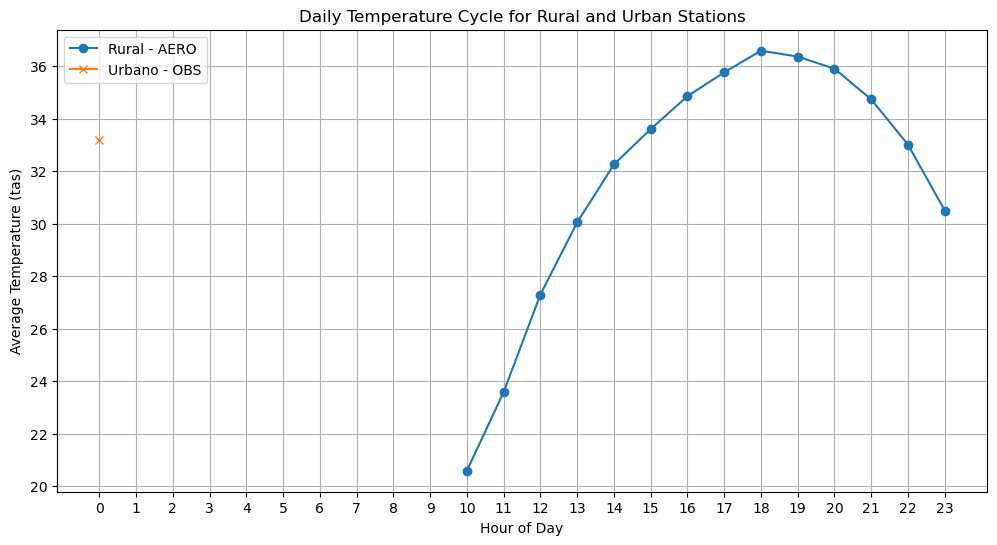

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert the 'DATE' column to datetime, and coerce errors to NaT (Not a Time)
df_exceedance['DATE'] = pd.to_datetime(df_exceedance['DATE'], errors='coerce')
df_rur['DATE'] = pd.to_datetime(df_rur['DATE'], errors='coerce')
df_urb['DATE'] = pd.to_datetime(df_urb['DATE'], errors='coerce')

# Drop rows where 'DATE' is NaT (invalid date)
df_rur = df_rur.dropna(subset=['DATE'])
df_urb = df_urb.dropna(subset=['DATE'])

# Now extract the date (without the time) from df_rur and df_urb to match the format in df_exceedance
df_rur['DATE_only'] = df_rur['DATE'].dt.date
df_urb['DATE_only'] = df_urb['DATE'].dt.date

# Filter rows in df_rur and df_urb to match the dates in df_exceedance
df_rur_filtered = df_rur[df_rur['DATE_only'].isin(df_exceedance['DATE'].dt.date)]
df_urb_filtered = df_urb[df_urb['DATE_only'].isin(df_exceedance['DATE'].dt.date)]

# Extract the hour of each date in df_rur and df_urb for daily cycle
df_rur_filtered['hour'] = df_rur_filtered['DATE'].dt.hour
df_urb_filtered['hour'] = df_urb_filtered['DATE'].dt.hour

# Create a single plot for both df_rur and df_urb
plt.figure(figsize=(12, 6))

# Plot for each station in df_rur
station_names_rur = df_rur_filtered['Station Name'].unique()
for station in station_names_rur:
    # Filter data for each station in df_rur
    station_data_rur = df_rur_filtered[df_rur_filtered['Station Name'] == station]
    # Calculate the daily average temperature ('tas') by hour
    daily_cycle_rur = station_data_rur.groupby('hour')['tas'].mean()
    
    # Plot the daily cycle for the station
    plt.plot(daily_cycle_rur.index, daily_cycle_rur.values, label=f'Rural - {station}', marker='o')

# Plot for each station in df_urb
station_names_urb = df_urb_filtered['Station Name'].unique()
for station in station_names_urb:
    # Filter data for each station in df_urb
    station_data_urb = df_urb_filtered[df_urb_filtered['Station Name'] == station]
    # Calculate the daily average temperature ('tas') by hour
    daily_cycle_urb = station_data_urb.groupby('hour')['tas'].mean()
    
    # Plot the daily cycle for the station
    plt.plot(daily_cycle_urb.index, daily_cycle_urb.values, label=f'Urbano - {station}', marker='x')

# Finalize the plot
plt.title('Daily Temperature Cycle for Rural and Urban Stations')
plt.xlabel('Hour of Day')
plt.ylabel('Average Temperature (tas)')
plt.xticks(range(0, 24, 1))  # Display all hours
plt.legend()
plt.grid(True)
plt.show()


### Select coincident period between Model and Observations

In [18]:
ds_RCM_selected = ds_RCM.sel(time=ds_RCM.time.dt.year.isin([2018, 2021]))

In [19]:
import numpy as np

def find_nearest_point(ds, lat, lon, lat_var='lat', lon_var='lon'):
    """
    Finds the nearest grid point in an xarray.Dataset to a given latitude and longitude.

    Parameters:
        ds (xarray.Dataset): The dataset containing latitude and longitude variables.
        lat (float): Latitude of the point to find.
        lon (float): Longitude of the point to find.
        lat_var (str): Name of the latitude variable in the dataset. Default is 'lat'.
        lon_var (str): Name of the longitude variable in the dataset. Default is 'lon'.

    Returns:
        xarray.Dataset: A dataset for the nearest latitude and longitude.
    """
    # Extract the latitude and longitude arrays from the dataset
    latitudes = ds[lat_var].values
    longitudes = ds[lon_var].values

    # If longitude range is 0 to 360, convert input longitude to the same range
    if np.max(longitudes) > 180:
        lon = lon % 360

    # Compute the absolute differences
    lat_diff = np.abs(latitudes - lat)
    lon_diff = np.abs(longitudes - lon)

    # Find the indices of the nearest latitude and longitude
    lat_idx = np.argmin(lat_diff)
    lon_idx = np.argmin(lon_diff)

    # Use the indices to select the nearest point in the dataset
    ds_selected = ds.isel(lat=lat_idx, lon=lon_idx)

    # Return the selected dataset
    return ds_selected


In [20]:
selected_row = df[(df['city'] == city) & (df['urban'] == "Urban")].iloc[0]  

lat = selected_row['lat']
lon = selected_row['lon']

ds_selected_urb = find_nearest_point(ds_RCM_selected, lat, lon)

selected_row = df[(df['city'] == city) & (df['urban'] == "Rural")].iloc[0]  

lat = selected_row['lat']
lon = selected_row['lon']

ds_selected_rur = find_nearest_point(ds_RCM_selected, lat, lon)

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_temperatures_and_anomalies_annual(df_urb, df_rur, ds_urb, ds_rur, var, city):
    """
    Function to plot temperature data and anomalies for urban and rural stations.
    """
    # Convert 'DATE' to datetime and extract the month for the DataFrames
    df_urb['month'] = pd.to_datetime(df_urb['DATE']).dt.month
    df_rur['month'] = pd.to_datetime(df_rur['DATE']).dt.month

    # Group by month and station for mean (urban and rural) in DataFrames
    df_urb_mean = df_urb.groupby(['month', 'Station Name'])[var].mean().unstack('Station Name')
    df_rur_mean = df_rur.groupby(['month', 'Station Name'])[var].mean().unstack('Station Name')

    # For the xarray datasets (ds_urb and ds_rur), calculate the mean by month
    # Ensure the time dimension is a DateTime object
    ds_urb['time'] = pd.to_datetime(ds_urb['time'].values)
    ds_rur['time'] = pd.to_datetime(ds_rur['time'].values)
    
    ds_urb_mean = ds_urb[var].groupby('time.month').mean('time')
    ds_rur_mean = ds_rur[var].groupby('time.month').mean('time')
    if var == 'pr':
    # Convert from kg/m²/s to kg/m²/day by multiplying by the number of seconds in a day
        ds_urb_mean = ds_urb_mean * (24 * 60 * 60)  # Precipitation in kg/m²/day
        ds_rur_mean = ds_rur_mean * (24 * 60 * 60)  # Precipitation in kg/m²/day
            

    # Initialize lists to store anomalies
    anomaly_station = []
    anomaly_model = []

    # Iterate over the months to calculate the anomalies
    for month in range(1, 13):  # Loop over months (1 to 12)
        urban_station_names = df_urb_mean.columns
        rural_station_names = df_rur_mean.columns
        anomaly_station.append(df_urb_mean.loc[month, urban_station_names[0]] - df_rur_mean.loc[month, rural_station_names[0]])

        # Calculate the anomaly for the model (Urban - Rural)
        anomaly_model.append(ds_urb_mean.sel(month=month) - ds_rur_mean.sel(month=month))

    # Convert the list of anomalies into DataFrames or arrays
    anomaly_station = pd.DataFrame(anomaly_station, index=range(1, 13))
    anomaly_model = np.array(anomaly_model)

    # Create figure with 2 rows and 1 column (one for the annual cycle, one for anomalies)
    fig, axes = plt.subplots(2, 1, figsize=(18, 10), gridspec_kw={'hspace': 0.4})

    # Plot for the annual cycle (urban and rural temperatures)
    axes[0].plot(df_urb_mean.index, df_urb_mean, label=f'Urban Station')
    axes[0].plot(df_rur_mean.index, df_rur_mean, label=f'Rural Station')
    
    # Plot xarray data for the annual cycle
    axes[0].plot(ds_urb_mean['month'], ds_urb_mean, label='Urban Model', linestyle='--', color='b')
    axes[0].plot(ds_rur_mean['month'], ds_rur_mean, label='Rural Model', linestyle='--', color='g')

    # Set dynamic labels and titles based on 'var' and 'city'
    axes[0].set_xlabel('Month')
    axes[0].set_ylabel(f'{var} (°C)' if var in ['tasmin', 'tasmax'] else f'{var}')
    axes[0].set_title(f'Annual Cycle of {var.capitalize()} in {city}')
    axes[0].grid(True)
    axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Plot for the anomalies (Urban - Rural) temperatures
    axes[1].plot(range(1, 13), anomaly_station, label='Anomaly Station', color='g')
    axes[1].plot(ds_urb_mean['month'], anomaly_model, label='Anomaly Model', linestyle='--', color='b')

    # Set dynamic labels and titles based on 'var' and 'city'
    axes[1].set_xlabel('Month')
    axes[1].set_ylabel(f'{var} Anomaly (Urban - Rural) (°C)' if var in ['tasmin', 'tasmax'] else f'{var} Anomaly (Urban - Rural)')
    axes[1].set_title(f'{var.capitalize()} Anomaly (Urban - Rural) in {city}')
    axes[1].grid(True)
    axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()


In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_temperatures_and_anomalies_daily(df_urb, df_rur, ds_urb, ds_rur, var, city):
    """
    Function to plot temperature data and anomalies for urban and rural stations.
    """
    df_urb['DATE'] = pd.to_datetime(df_urb['DATE'])
    df_rur['DATE'] = pd.to_datetime(df_rur['DATE'])

    # Filter data for DJF and JJA
    df_djf_urb = df_urb[df_urb['DATE'].dt.month.isin([12, 1, 2])]
    df_djf_rur = df_rur[df_rur['DATE'].dt.month.isin([12, 1, 2])]
    
    df_jja_urb = df_urb[df_urb['DATE'].dt.month.isin([6, 7, 8])]
    df_jja_rur = df_rur[df_rur['DATE'].dt.month.isin([6, 7, 8])]

    # Extract hour from 'DATE' for grouping
    for df in [df_jja_urb, df_jja_rur, df_djf_urb, df_djf_rur]:
        df['hour'] = df['DATE'].dt.hour

    # Group by hour and station for mean values
    df_urb_jja_mean = df_jja_urb.groupby(['hour', 'Station Name'])[var].mean().unstack('Station Name')
    df_rur_jja_mean = df_jja_rur.groupby(['hour', 'Station Name'])[var].mean().unstack('Station Name')
    df_urb_djf_mean = df_djf_urb.groupby(['hour', 'Station Name'])[var].mean().unstack('Station Name')
    df_rur_djf_mean = df_djf_rur.groupby(['hour', 'Station Name'])[var].mean().unstack('Station Name')

    # Filter xarray datasets for DJF and JJA
    ds_urb_djf = ds_urb.sel(time=ds_urb['time.month'].isin([12, 1, 2]))
    ds_rur_djf = ds_rur.sel(time=ds_rur['time.month'].isin([12, 1, 2]))
    ds_urb_jja = ds_urb.sel(time=ds_urb['time.month'].isin([6, 7, 8]))
    ds_rur_jja = ds_rur.sel(time=ds_rur['time.month'].isin([6, 7, 8]))

    # Calculate hourly means for xarray datasets
    ds_urb_djf_mean = ds_urb_djf[var].groupby(ds_urb_djf['time.hour']).mean(dim='time')
    ds_rur_djf_mean = ds_rur_djf[var].groupby(ds_rur_djf['time.hour']).mean(dim='time')
    ds_urb_jja_mean = ds_urb_jja[var].groupby(ds_urb_jja['time.hour']).mean(dim='time')
    ds_rur_jja_mean = ds_rur_jja[var].groupby(ds_rur_jja['time.hour']).mean(dim='time')
    
    if var == 'pr':
    # Convert from kg/m²/s to kg/m²/day by multiplying by the number of seconds in a day
        ds_urb_djf_mean = ds_urb_djf_mean * (24 * 60 * 60)  # Precipitation in kg/m²/day
        ds_rur_djf_mean = ds_rur_djf_mean * (24 * 60 * 60)  # Precipitation in kg/m²/day
        ds_urb_jja_mean = ds_urb_jja_mean * (24 * 60 * 60)  # Precipitation in kg/m²/day
        ds_rur_jja_mean = ds_rur_jja_mean * (24 * 60 * 60)  # Precipitation in kg/m²/day

    # Calculate anomalies
    anomaly_station_jja = df_urb_jja_mean.mean(axis=1) - df_rur_jja_mean.mean(axis=1)
    anomaly_station_djf = df_urb_djf_mean.mean(axis=1) - df_rur_djf_mean.mean(axis=1)
    anomaly_ds_jja = ds_urb_jja_mean - ds_rur_jja_mean
    anomaly_ds_djf = ds_urb_djf_mean - ds_rur_djf_mean

    # Create figure with 2 rows and 2 columns
    fig, axes = plt.subplots(2, 2, figsize=(18, 10), gridspec_kw={'hspace': 0.4})

    # Plot DJF annual cycle
    axes[0, 0].plot(df_urb_djf_mean.index, df_urb_djf_mean.mean(axis=1), label='Urban Station (DJF)', color='b')
    axes[0, 0].plot(df_rur_djf_mean.index, df_rur_djf_mean.mean(axis=1), label='Rural Station (DJF)', color='g')
    axes[0, 0].plot(ds_urb_djf_mean['hour'], ds_urb_djf_mean, label='Urban Model (DJF)', linestyle='--', color='b')
    axes[0, 0].plot(ds_rur_djf_mean['hour'], ds_rur_djf_mean, label='Rural Model (DJF)', linestyle='--', color='g')
    axes[0, 0].set_xlabel('Hour')
    axes[0, 0].set_ylabel(f'{var.capitalize()} (°C)')
    axes[0, 0].set_title(f'{var.capitalize()} Annual Cycle in {city} (Winter)')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Plot JJA annual cycle
    axes[0, 1].plot(df_urb_jja_mean.index, df_urb_jja_mean.mean(axis=1), label='Urban Station (JJA)', color='b')
    axes[0, 1].plot(df_rur_jja_mean.index, df_rur_jja_mean.mean(axis=1), label='Rural Station (JJA)', color='g')
    axes[0, 1].plot(ds_urb_jja_mean['hour'], ds_urb_jja_mean, label='Urban Model (JJA)', linestyle='--', color='b')
    axes[0, 1].plot(ds_rur_jja_mean['hour'], ds_rur_jja_mean, label='Rural Model (JJA)', linestyle='--', color='g')
    axes[0, 1].set_xlabel('Hour')
    axes[0, 1].set_ylabel(f'{var.capitalize()} (°C)')
    axes[0, 1].set_title(f'{var.capitalize()} Annual Cycle in {city} (Summer)')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Plot DJF anomalies
    axes[1, 0].plot(anomaly_station_djf.index, anomaly_station_djf, label='Station Anomaly (DJF)', color='red')
    axes[1, 0].plot(anomaly_ds_djf['hour'], anomaly_ds_djf, label='Model Anomaly (DJF)', linestyle='--', color='red')
    axes[1, 0].set_xlabel('Hour')
    axes[1, 0].set_ylabel(f'{var.capitalize()} Anomaly (°C)')
    axes[1, 0].set_title(f'{var.capitalize()} Anomaly in {city} (Winter)')
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    # Plot JJA anomalies
    axes[1, 1].plot(anomaly_station_jja.index, anomaly_station_jja, label='Station Anomaly (JJA)', color='red')
    axes[1, 1].plot(anomaly_ds_jja['hour'], anomaly_ds_jja, label='Model Anomaly (JJA)', linestyle='--', color='red')
    axes[1, 1].set_xlabel('Hour')
    axes[1, 1].set_ylabel(f'{var.capitalize()} Anomaly (°C)')
    axes[1, 1].set_title(f'{var.capitalize()} Anomaly in {city} (Summer)')
    axes[1, 1].legend()
    axes[1, 1].grid(True)

    # Adjust layout and show
    plt.tight_layout()
    plt.show()


/tmp/ipykernel_135349/3851184078.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df['DATE'].dt.hour
/tmp/ipykernel_135349/3851184078.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df['DATE'].dt.hour
/tmp/ipykernel_135349/3851184078.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

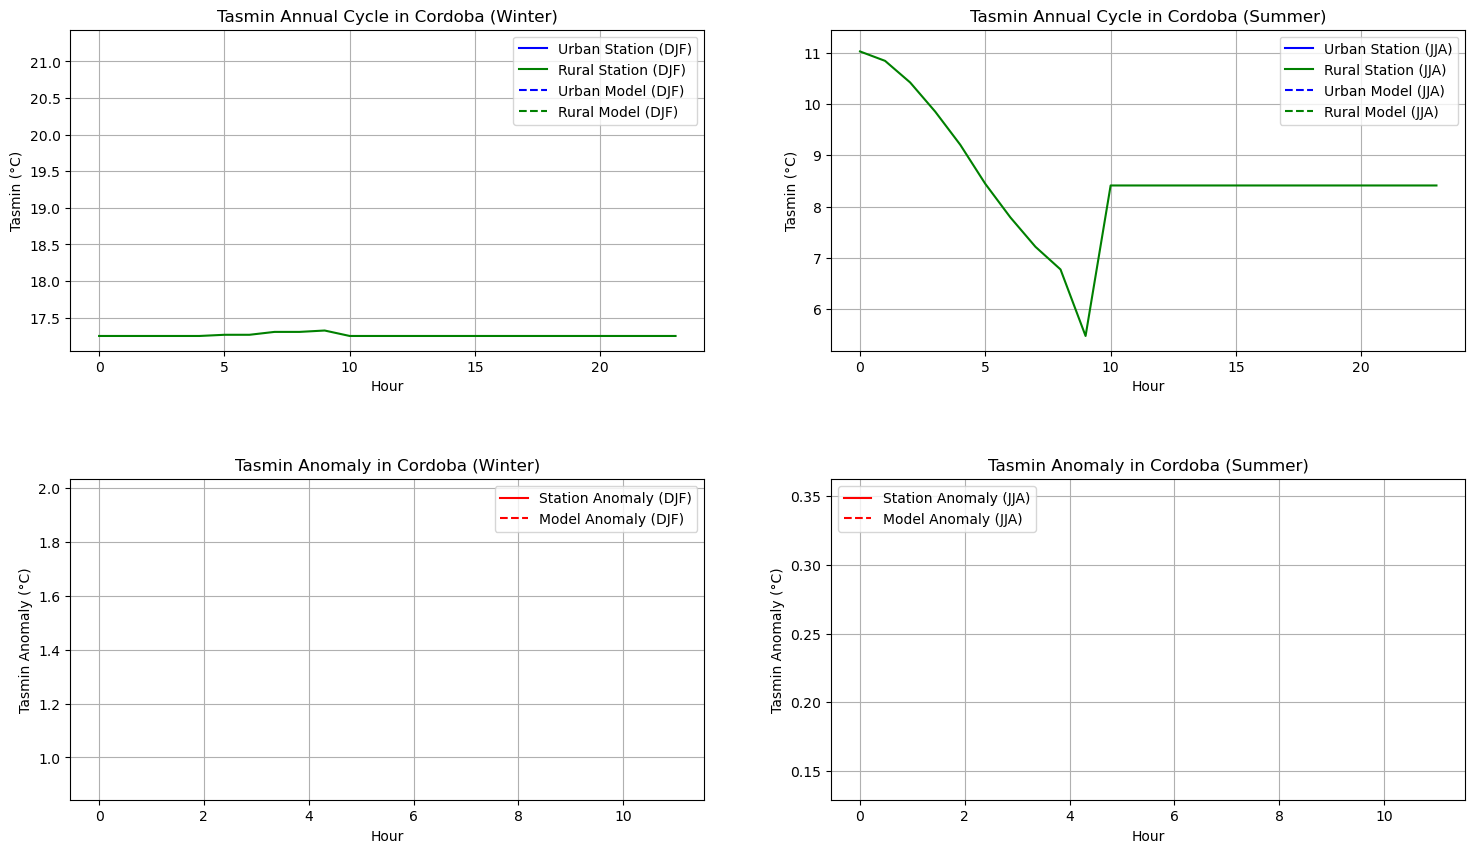

In [23]:
plot_temperatures_and_anomalies_daily(df_urb, df_rur,ds_selected_urb,ds_selected_rur, variable, city)


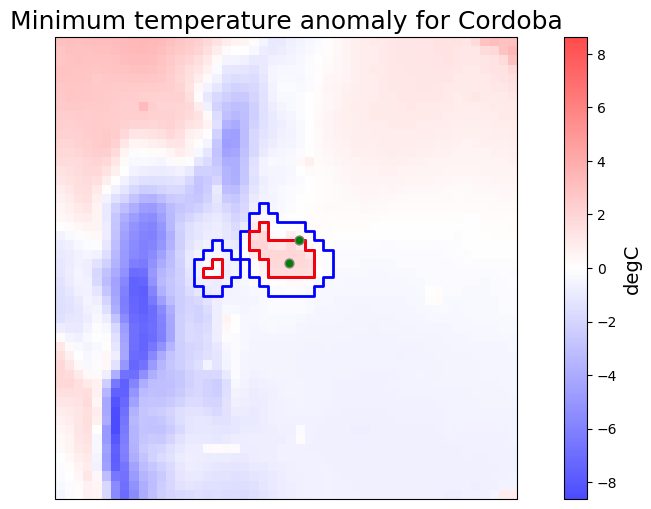

In [24]:
cachefile = f"{output_dir}/{variable}_{base_filename}_map-ur.nc"

fig = plot_climatology(variable, URBAN, ds_RCM,  urmask,  cachefile, 
                       city = city, valid_stations = df, time_series = time_series_obs,
                       alpha_urb_borders = 1,
                       linewidth_urb_borders = 0.6
                      )